In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from numpy.linalg import eig
from sklearn.preprocessing import StandardScaler
import matplotlib.pylab as pl


In [4]:
# read in data
df = pd.read_csv("bond_data_final.csv", index_col=0)
df.head()

,16-Jan,17-Jan,18-Jan,19-Jan,20-Jan,23-Jan,24-Jan,25-Jan,26-Jan,27-Jan,30-Jan
CAN 0.25 AUG 23,97.80,97.801,97.833,97.841,97.828,97.845,97.866,97.903,97.909,97.903,97.918
CAN 2.25 MAR 24,97.93,97.870,97.950,97.920,97.870,97.860,97.870,97.920,97.920,97.840,97.780
CAN 1.5 SEP 24,96.48,96.450,96.580,96.500,96.400,96.400,96.390,96.470,96.480,96.290,96.240
CAN 1.25 MAR 25,95.38,95.420,95.610,95.590,95.440,95.380,95.340,95.470,95.500,95.300,95.190
CAN 0.5 SEP 25,92.74,92.750,93.030,93.030,92.870,92.820,92.810,92.970,93.000,92.720,92.610


# Get YTM Curve

In [5]:
# get present value of the bond with given ytm
def get_pv_ytm(c, time_to_maturity, rate, frequency=2, first_cf_time=0, fv=100):
  pv = 0
  for t in range(first_cf_time, int(time_to_maturity * frequency) + 1): # t = 0, 1, 2, 3, ...
    if t == int(time_to_maturity * frequency):
      cf_t = fv + c
    else:
      cf_t = c
    pv += cf_t / ((1 + rate/frequency) ** t)
  return pv

# calculate the ytm of the bond
def get_ytm(bond_price, time_to_maturity, coupon_percent):
  ytm = 0.04
  c = coupon_percent / 2
  pv = get_pv_ytm(c, time_to_maturity, ytm)
  if pv < bond_price:
    while pv < bond_price:
      ytm -= 0.00001
      pv = get_pv_ytm(c, time_to_maturity, ytm)
  elif pv > bond_price:
    while pv > bond_price:
      ytm += 0.00001
      pv = get_pv_ytm(c, time_to_maturity, ytm)
  return ytm


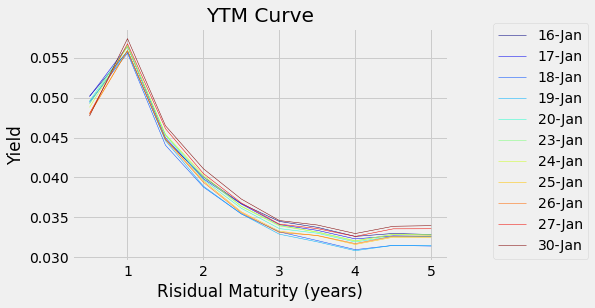

In [6]:
colors = pl.cm.jet(np.linspace(0,1,11))

# define the list of bonds and their respective coupons
bond_list = ['CAN 0.25 AUG 23', 'CAN 2.25 MAR 24', 'CAN 1.5 SEP 24', 'CAN 1.25 MAR 25', 'CAN 0.5 SEP 25', 'CAN 0.25 MAR 26', 'CAN 1.0 SEP 26', 'CAN 1.25 MAR 27', 'CAN 2.75 SEP 27', 'CAN 3.5 MAR 28']
coupon_percents = [0.25, 2.25, 1.5, 1.25, 0.5, 0.25, 1.0, 1.25, 2.75, 3.5]

x = [i/2 for i in range(1, 11)]
YTMS = []
for d in range(len(df.columns)):
  ytms = []
  for i in range(len(bond_list)):
    ytms.append(get_ytm(df[df.columns[d]][bond_list[i]], 0.5 + i/2, coupon_percents[i]))
  plt.plot(x, ytms, linewidth=0.5, label=df.columns[d], color=colors[d])
  YTMS.append(ytms)
YTMS = np.array(YTMS)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel('Risidual Maturity (years)')
plt.ylabel('Yield')
plt.title('YTM Curve')
plt.show()

In [7]:
YTMS

array([[0.05017, 0.0558 , 0.04475, 0.04006, 0.03671, 0.03449, 0.03375,
        0.03261, 0.03298, 0.03285],
       [0.05015, 0.05644, 0.04497, 0.03983, 0.03667, 0.03408, 0.03337,
        0.0323 , 0.03268, 0.03261],
       [0.04948, 0.05558, 0.04404, 0.0388 , 0.03543, 0.03318, 0.03209,
        0.03095, 0.03149, 0.0314 ],
       [0.04931, 0.0559 , 0.04461, 0.03891, 0.03543, 0.03289, 0.03193,
        0.03082, 0.03149, 0.03145],
       [0.04958, 0.05644, 0.04533, 0.03972, 0.03613, 0.03359, 0.03301,
        0.03191, 0.03263, 0.03264],
       [0.04923, 0.05655, 0.04533, 0.04006, 0.03636, 0.03393, 0.03317,
        0.03207, 0.03288, 0.03285],
       [0.04879, 0.05644, 0.0454 , 0.04027, 0.0364 , 0.03401, 0.03314,
        0.03202, 0.03285, 0.03277],
       [0.04801, 0.0559 , 0.04483, 0.03956, 0.03569, 0.03326, 0.0327 ,
        0.0316 , 0.03251, 0.03244],
       [0.04789, 0.0559 , 0.04475, 0.03939, 0.03556, 0.03311, 0.03273,
        0.03171, 0.03263, 0.03266],
       [0.04801, 0.05676, 0.04612, 0.

# Get Spot Curve

In [8]:
# calculate the present value of the bond's cash flows up until nperiods by discounting each CF with the appropriate zero rate
def get_pv(coupon, nperiods, zeros):
  pv = 0
  pv += coupon # the first coupon payment at "t=0" (in MAR 23)
  for i in range(1, nperiods + 1): 
    pv += coupon / ((1 + zeros[i-1]/2) ** i)
  return pv

# calculate the spot rates using bootstrapping for a series of prices and coupons of different maturities
def get_spot_curve(prices, coupons):
  zeros = []
  z_1 = ((coupons[0]/2 + 100) / (prices[0] - coupons[0]/2) - 1) * 2
  zeros.append(z_1)
  for i in range(2, 11):
    price = prices[i-1]
    coupon = coupons[i-1]/2
    front_pv = get_pv(coupon, i-1, zeros)
    z = (np.power((coupon + 100) / (price - front_pv), 1/i) - 1) * 2
    zeros.append(z)
  return zeros

[0.05016636805733299, 0.055825332251882465, 0.04468019611375773, 0.03996207369609284, 0.0366685570122125, 0.034469556110933386, 0.03365114263997171, 0.032471974316823804, 0.03272886048310886, 0.0325596240582402]
[0.05014537859863211, 0.05647016484966905, 0.04489393125983909, 0.039739703716003216, 0.03662353715015776, 0.03405693353320238, 0.03326274995606138, 0.032159709908728296, 0.03243029932423225, 0.03231854742205442]
[0.049473942768248236, 0.05561454408906297, 0.04396069677265535, 0.03870750073853868, 0.03538482797222997, 0.03316236425286778, 0.031983695414019575, 0.030811048500140714, 0.03123616205258717, 0.031102467078767848]
[0.04930615252364001, 0.055937690612748, 0.04453730623353547, 0.03881343725412201, 0.035383495308290325, 0.032863130784586136, 0.03182172009179052, 0.03066872478700411, 0.031238262087431856, 0.031151457839416086]
[0.049578825624597034, 0.05647342617038076, 0.04525708019383501, 0.03962927272255712, 0.036090044449330616, 0.033570794028851214, 0.032910154597667

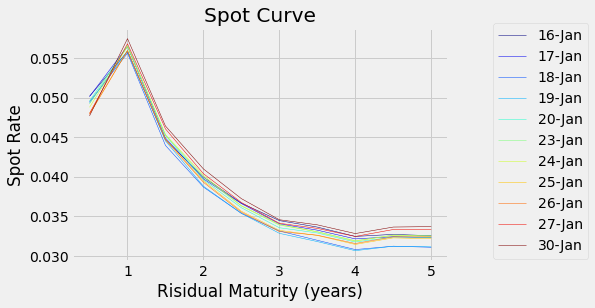

In [9]:
for d in range(len(df.columns)):
  zeros = get_spot_curve(df[df.columns[d]], coupon_percents)
  print(zeros)
  plt.plot(x, zeros, linewidth=0.5, label=df.columns[d], color=colors[d])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel('Risidual Maturity (years)')
plt.ylabel('Spot Rate')
plt.title('Spot Curve')
plt.show()

# Get Forward Curve

In [11]:
# calculate the product of all the (1 + forward rate)'s
def get_previous_forward_product(forwards, nperiods):
  factor = 1
  for i in range(1, nperiods + 1):
    factor /= 1 + forwards[i-1]/2
  return factor

# get the forward rates for one day of bond data
def get_forward_curve(zeros):
  forwards = []
  f_1 = zeros[0]
  forwards.append(f_1)
  for i in range(2, 11):
    factor = get_previous_forward_product(forwards, i-1)
    f = ((((1 + zeros[i-1]/2) ** i) * factor) - 1) * 2
    forwards.append(f)
  return forwards

[0.05016636805733299, 0.061499916581584824, 0.02257085787783053, 0.02587292873390279, 0.023547578290149307, 0.023510114454569297, 0.028747570930161892, 0.02423691789235649, 0.03478511900974812, 0.0310371301396426]
[0.05014537859863211, 0.06281446333702778, 0.02193659124413383, 0.024354838663682266, 0.024206404748020383, 0.021272351466904205, 0.028504156011550208, 0.024455166512967974, 0.034596312129873574, 0.03131305676927809]
[0.049473942768248236, 0.06177354378215982, 0.02085083422675238, 0.023028781556357014, 0.022148201434600168, 0.022086393768370183, 0.024926017828630354, 0.02262144663992549, 0.0346402756713613, 0.029899608233108665]
[0.04930615252364001, 0.06259068830532888, 0.02192583581994567, 0.021737797958206517, 0.02172133322096448, 0.02030804451324375, 0.025584449912937846, 0.022616056962183162, 0.03580031478429646, 0.030370386517948766]
[0.049578825624597034, 0.06339121953807059, 0.02300758199244024, 0.02283859412138156, 0.021994438673622607, 0.02102122082106206, 0.0289508

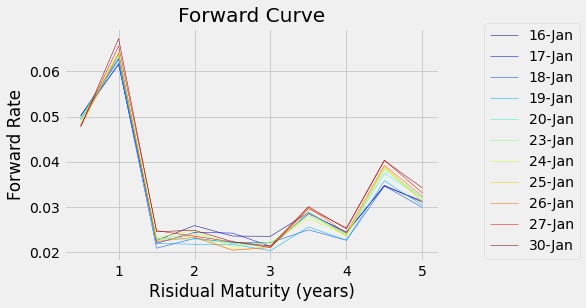

In [12]:
for d in range(len(df.columns)):
  zeros = get_spot_curve(df[df.columns[d]], coupon_percents)
  forwards = get_forward_curve(zeros)
  print(forwards)
  plt.plot(x, forwards, linewidth=0.5, label=df.columns[d], color=colors[d])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel('Risidual Maturity (years)')
plt.ylabel('Forward Rate')
plt.title('Forward Curve')
plt.show()

In [13]:
# Get the forward rates one year forward
def get_one_year_forward(forwards):
  return forwards[2:]

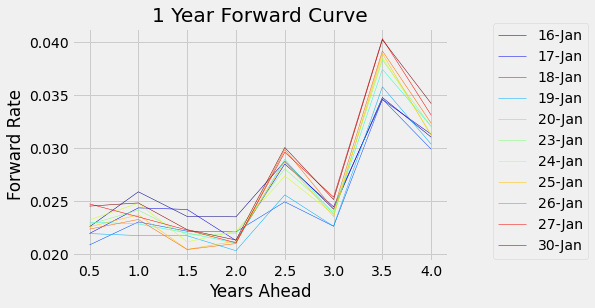

In [14]:
FORWARDS = []
for d in range(len(df.columns)):
  zeros = get_spot_curve(df[df.columns[d]], coupon_percents)
  forwards = get_forward_curve(zeros)
  one_yr_forward = get_one_year_forward(forwards)
  plt.plot(x[:-2], one_yr_forward, linewidth=0.5, label=df.columns[d], color=colors[d])
  FORWARDS.append(one_yr_forward)
FORWARDS = np.array(FORWARDS)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel('Years Ahead')
plt.ylabel('Forward Rate')
plt.title('1 Year Forward Curve')
plt.show()

# PCA

In [15]:
YTMS = YTMS[:, [1, 3, 5, 7, 9]]
FORWARDS = FORWARDS[:, [1, 3, 5, 7]]

In [16]:
YTMS = pd.DataFrame(YTMS)
FORWARDS = pd.DataFrame(FORWARDS)
YTMS_returns = np.log(YTMS/YTMS.shift()).dropna()
FORWARDS_returns = np.log(FORWARDS/FORWARDS.shift()).dropna()

In [17]:
def covariance_matrix(data):
    sc = StandardScaler()
    cov_matrix = np.cov(sc.fit_transform(data).T)
    return cov_matrix

In [18]:
covar_YTMS = covariance_matrix(YTMS_returns)
print(covar_YTMS)

[[1.11111111 0.93616388 0.85218668 0.87622959 0.87109726]
 [0.93616388 1.11111111 1.08453257 1.03616382 1.01835041]
 [0.85218668 1.08453257 1.11111111 1.02301566 0.99744032]
 [0.87622959 1.03616382 1.02301566 1.11111111 1.10671039]
 [0.87109726 1.01835041 0.99744032 1.10671039 1.11111111]]


In [19]:
covar_FORWARDS = covariance_matrix(FORWARDS_returns)
print(covar_FORWARDS)

[[ 1.11111111  0.77939393  0.45880631  0.43368204]
 [ 0.77939393  1.11111111 -0.08644098 -0.09249242]
 [ 0.45880631 -0.08644098  1.11111111  0.92929607]
 [ 0.43368204 -0.09249242  0.92929607  1.11111111]]


In [20]:
eigenvalues_YTM, eigenvectors_YTM = eig(covar_YTMS)
print(eigenvalues_YTM)

# explained variability of the first eigenvector
print(eigenvalues_YTM[0] / np.sum(eigenvalues_YTM))

[5.04002495e+00 3.26562278e-01 1.69598365e-01 1.68007618e-02
 2.56919656e-03]
0.9072044916689509


In [21]:
eigenvectors_YTM

array([[-0.41040864, -0.89228493,  0.10231514,  0.15769443,  0.0075125 ],
       [-0.46074175,  0.02541976, -0.42663837, -0.77572515, -0.05745497],
       [-0.45077206,  0.24491404, -0.60163085,  0.5963938 ,  0.13847894],
       [-0.45828112,  0.27087663,  0.39908526,  0.11620089, -0.73745005],
       [-0.45394355,  0.26424309,  0.53505381, -0.06476692,  0.65850855]])

In [22]:
eigenvalues_FORWARDS, eigenvectors_FORWARDS = eig(covar_FORWARDS)
print(eigenvalues_FORWARDS)

# explained variability of the first eigenvector
eigenvalues_FORWARDS[0] / np.sum(eigenvalues_FORWARDS)

[2.41888776 1.67207703 0.16554381 0.18793584]


0.5442497460675129

In [23]:
eigenvectors_FORWARDS

array([[ 0.53422464,  0.44574426,  0.61285923, -0.37459265],
       [ 0.2399772 ,  0.73469772, -0.53520089,  0.34086686],
       [ 0.57647057, -0.35632818, -0.54504056, -0.49360177],
       [ 0.56982161, -0.36682632,  0.20222356,  0.70699888]])